#### Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import fftpack
from scipy.signal import butter
from scipy.signal import lfilter

#### Input Data and Analysis Parameters

In [4]:
#insert file path between single quotes
sensor_data_filepath = r'C:\Users\lross\Documents\Python\Vibration\accelerometer_data.csv'

In [5]:
#input data and analysis parameters
sampling_rate = 256   #the designated sampling rate of the sensor when data collection was started
f_lower = 40          #lower-bound frequency of range of concern -- update based on believed source frequency
f_upper = 60          #upper-bound frequency of range of concern -- update based on believed source frequency

#### Extract and Clean Data

In [7]:
recorded_data = pd.read_csv(sensor_data_filepath)

In [8]:
accel = recorded_data.iloc[:,1]  #isolating the acceleration data by removing the timestamp
accel_avg = np.mean(accel)
accel_cleaned = (accel - accel_avg) * 1000  #removes the offset (sometime equal to 1g) and converts to milli-g

#### Establish Domains and Perform Analysis

In [10]:
#Establish time and sampling parameters
N = int(accel_cleaned.size)
T = 1/sampling_rate

#Define domains
#reestablish the time domain based on duration (i.e. seconds), instead of timestamp:
time_domain = np.linspace(0.0, N*T, N)

#set the frequency domain from 0 to 1/2 of the sampling rate, which is the highest observalbe freq:
freq_domain = np.linspace(0.0, .5 * sampling_rate, int(N/2))

#Perform FFT
fft = fftpack.fft(np.array(accel))

#### Data Filtering

In [12]:
#Create a function to filter the data for only the frequency range of concern
def band_pass_filter(accel_data, time_step, f_lower, f_upper):
    if f_lower < 0:  #applies zero when lower frequency input is negative
        f_lower = 0
    if f_upper < 0:  #applies a conservatively high frequency when upper frequency input is negative
        f_upper = 1000
    f_low_rel = f_lower*time_step*2  #setting the critical frequency for a butterworth filter
    f_up_rel = f_upper*time_step*2  #setting the critical frequency for a butterworth filter
    b, a = butter(3, [f_low_rel, f_up_rel], 'bandpass')  #calculate coeff. from a butterworth filter
    filtered_accel = lfilter(b,a,accel_data)  #apply the butterworth filter coefficients
    return filtered_accel

In [13]:
center_freqs = np.array([0.5 * 2 ** (n * 1 / 3.) for n in range(0, 24)])  #standard freqs for 1/3 octave bands
start_freqs = 2. ** (-1 / 6.) * center_freqs  #define the starting frequency of each 1/3 octave band
rms_accel=[]
for f in start_freqs:  #apply filter to each 1/3 octave band
    band = band_pass_filter(accel_cleaned, T, f, f*2**(1/3.))  #last func argument calculates end of 1/3 octave band
    rms = np.sqrt(np.mean(band**2))
    rms_accel.append(rms)

#### Plots

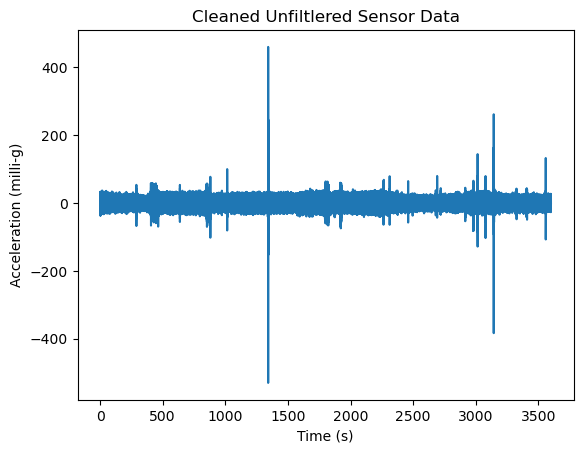

In [15]:
#Cleaned but unfiltered acceleration plot
plt.figure()
plt.plot(time_domain, accel_cleaned)
plt.title('Cleaned Unfiltlered Sensor Data')
plt.xlabel('Time (s)')
plt.ylabel ('Acceleration (milli-g)')
plt.show()

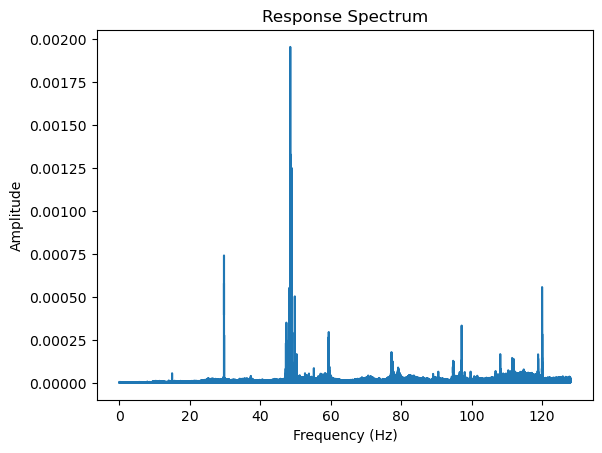

In [16]:
#Response spectrum plot
plt.figure()
plt.plot(freq_domain[1:],2.0/N * np.abs(fft[0:int(N/2)])[1:])
plt.title('Response Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

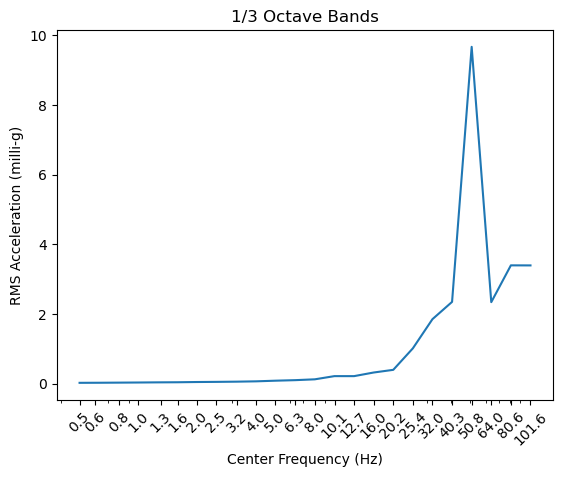

In [17]:
#1/3 octave bands
plt.figure
plt.plot(center_freqs,rms_accel)
plt.xscale('log')
center_freq_label = np.round(center_freqs,1)
plt.xticks(center_freq_label, labels=center_freq_label, rotation=45)
plt.title('1/3 Octave Bands')
plt.xlabel('Center Frequency (Hz)')
plt.ylabel('RMS Acceleration (milli-g)')
plt.show()

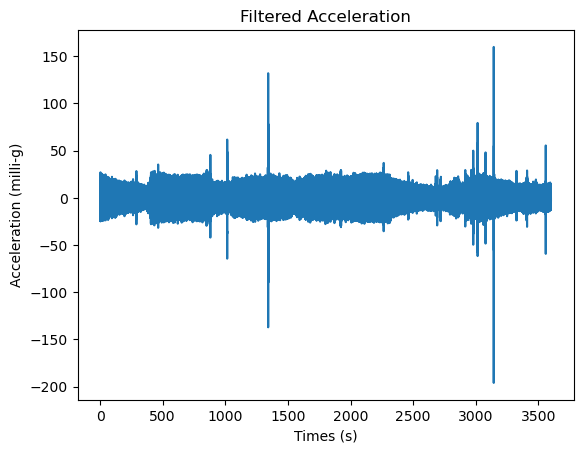

In [18]:
#Filtered acceleration plot
accel_filtered = band_pass_filter(accel_cleaned, T, f_lower, f_upper)  #Filter acceleration data for frequency range of concern

plt.figure()
plt.plot(time_domain, accel_filtered)
plt.title('Filtered Acceleration')
plt.xlabel('Times (s)')
plt.ylabel('Acceleration (milli-g)')
plt.show()